Peligros microscópicos: un estudio con estadística multivariada de la contaminación por PM10 en Monterrey

Luis F. Villaseñor, Ernesto I. Borbón, J. de Jesús Gutiérrez, Gerardo Villegas

#Limpieza y preparación de los datos

In [ ]:
import pandas as pd
import numpy as np
import datetime
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
import datetime
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from numpy import log
from sklearn.decomposition import PCA

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

Pasa a formato fecha los días y horas en los que se tomaron las medidas de los contaminantes y las variables meteorológicas.

In [ ]:
def leer(s, dayf):
    df = pd.read_csv(s)
    if dayf == 1:
        df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst = True)
    else:
        df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst = False)
    return df

Para revisar la normalidad de los datos

In [ ]:
def Benford(df):
    X=df.values
    X=X.tolist()
    X = [x for x in X if np.isnan(x) == False]
    X=[int(i) for i in X]
    X = [x for x in X if x !=0]
    list_of_nums = X

    letters = {
        '1': 0,
        '2': 0,
        '3': 0,
        '4': 0,
        '5': 0,
        '6': 0,
        '7': 0,
        '8': 0,
        '9': 0
    }

    for n in list_of_nums:
        first_digit = str(n)[0]
        letters[first_digit] += 1

    x = list(letters.keys())
    y = [round(val / len(list_of_nums), 4) for val in letters.values()]

    plt.title("Benford's Law distribution")
    plt.xlabel('First digit')
    plt.ylabel('Frequency')

    plt.ylim([0, 0.35])


    bars = plt.bar(x, y, color = 'DarkOrange')

    for bar in bars:
        height = bar.get_height()

        plt.annotate(f'{height}',
            xy = (bar.get_x() + bar.get_width() / 2, height),
            xytext = (0, 3),
            textcoords = 'offset points',
            ha = 'center',
            va = 'bottom'
        )

In [ ]:
dfs = []
dfpm10 = leer("pm10.csv", 1)
dfpm25 = leer("pm2.5.csv", 1)
dfO3 = leer("O3.csv", 1)
dfSO2 = leer("SO2.csv", 1)
dfCO = leer("CO.csv", 1)
dfNO = leer("NO.csv", 1)
dfNO2 = leer("NO2.csv", 1)
dfNOx = leer("NOx.csv", 1)
dfprs=leer("PRS CE.csv", 0)
dfrainf=leer("RAINF CE.csv", 0)
dfrainf["RAINF"]=25*dfrainf["RAINF"]
dfrh=leer("RH CE.csv", 0)
dfsr=leer("SR CE.csv", 0)
dftout=leer("TOUT CE.csv", 0)
dfwd=leer("WD CE.csv", 0)
dfws=leer("WS CE.csv", 0)

In [ ]:
dfs.append(dfpm10)
dfs.append(dfpm25)
dfs.append(dfO3)
dfs.append(dfSO2)
dfs.append(dfCO)
dfs.append(dfNO)
dfs.append(dfNO2)
dfs.append(dfNOx)
dfs.append(dfprs)
dfs.append(dfrainf)
dfs.append(dfrh)
dfs.append(dfsr)
dfs.append(dftout)
dfs.append(dfwd)
dfs.append(dfws)

In [ ]:
df=reduce(lambda x, y: pd.merge(x, y, on ='Fecha', how='outer'), dfs)

In [ ]:
df = df[:-1]

In [ ]:
df = df[df.columns[~df.columns.str.endswith('b')]]

In [ ]:
df = df.sort_values(by="Fecha", ignore_index =True)

In [ ]:
df = df.fillna(method = 'bfill',limit = 48).fillna(method ='ffill', limit = 48)

In [ ]:
df.isna().sum()

In [ ]:
df = df.dropna(axis = 0)

In [ ]:
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Date'] = df['Fecha'].dt.date

#Análsis exploratorio

In [ ]:
df_sinbadera = df[df.columns[~df.columns.str.endswith('b')]]

In [ ]:
df_sinbadera = df_sinbadera.sort_values(by="Fecha")
df_sinbadera = df_sinbadera.reset_index(drop=True)
df_sinbadera.tail()

In [ ]:
df_sinbadera.describe()

In [ ]:
Benford(df_sinbadera['PM10'])

In [ ]:
w = sns.boxplot(y=df_sinbadera['PM10'], color = 'DarkOrange')
plt.show()

In [ ]:
sns.histplot(data = df_sinbadera, x= 'PM10', binwidth = 10, color = 'DarkOrange')

In [ ]:
sns.histplot(log(df_sinbadera['PM10']), binwidth = 0.1, color = 'DarkOrange')

In [ ]:
fig = px.line(df_sinbadera, y="PM10", x="Fecha")
fig.update_traces(line_color='#e25f25')
fig.show()

##Creación de variables temporales

In [ ]:
df_sinbadera['Día'] = df_sinbadera['Fecha'].dt.day
df_sinbadera['mes'] = df_sinbadera['Fecha'].dt.month
df_sinbadera['Año'] = df_sinbadera['Fecha'].dt.year
df_sinbadera['dia-mes'] = df_sinbadera['Fecha'].dt.strftime('%d-%m %H:%M')

In [ ]:
seasonCond = [(df_sinbadera['Date'] >= datetime.date(2021,6,21)),(df_sinbadera['Date'] >= datetime.date(2021,3,21)),(df_sinbadera['Date'] >= datetime.date(2020,12,21)), (df_sinbadera['Date'] >= datetime.date(2020,9,22)), (df_sinbadera['Date'] >= datetime.date(2020,6,21)), (df_sinbadera['Date'] >= datetime.date(2020,3,21)), (df_sinbadera['Date'] >= datetime.date(2019,12,21)), (df_sinbadera['Date'] >= datetime.date(2019,9,22)), (df_sinbadera['Date'] >= datetime.date(2019,6,21)), (df_sinbadera['Date'] >= datetime.date(2019,3,21)), (df_sinbadera['Date'] >= datetime.date(2018,12,21)), (df_sinbadera['Date'] >= datetime.date(2018,9,22)), (df_sinbadera['Date'] >= datetime.date(2018,6,21)), (df_sinbadera['Date'] >= datetime.date(2018,3,21)), (df_sinbadera['Date'] >= datetime.date(2017,12,21)), (df_sinbadera['Date'] >= datetime.date(2017,9,22)), (df_sinbadera['Date'] >= datetime.date(2017,6,21)), (df_sinbadera['Date'] >= datetime.date(2017,3,21)), (df_sinbadera['Date'] >= datetime.date(2016,12,21))]

values = ['Sum','Spr','Inv', 'Aut', 'Sum', 'Spr', 'Inv', 'Aut', 'Sum', 'Spr', 'Inv', 'Aut', 'Sum', 'Spr', 'Inv', 'Aut', 'Sum', 'Spr', 'Inv']

df_sinbadera['Season'] = np.select(seasonCond, values)

In [ ]:
df_sinbadera['diaSemana'] = df_sinbadera['Fecha'].dt.dayofweek

In [ ]:
df_sinbadera['diaSemana'] = df_sinbadera['diaSemana'] + 1

In [ ]:
df_sinbadera['Hora'] = df_sinbadera['Fecha'].dt.strftime('%H:%M')

##Gráfica de caja

In [ ]:
sns.boxplot(data = df_sinbadera, x = 'Año', y = 'PM10')

In [ ]:
plt.rcParams["font.size"] = "15"
ax = sns.boxplot(data = df_sinbadera, x = 'Hora', y = 'PM10')
ax.tick_params(axis='x', rotation=90)

In [ ]:
sns.boxplot(data = df_sinbadera, x = 'Día', y = 'PM10')

In [ ]:
meteorologicas = list(df_sinbadera.columns)
meteorologicas = meteorologicas[9:16]
fig, axs = plt.subplots(len(meteorologicas), figsize=(15, 50))
for i in range(len(meteorologicas)):
    sns.boxplot(ax = axs[i], data = df_sinbadera, x = 'Hora', y = meteorologicas[i])

##Imputación de datos

Se revisan los datos faltantes de cada variable

In [ ]:
df_sinbadera.info()

In [ ]:
df_sb_relle = df_sinbadera.fillna(method = 'bfill',limit = 48).fillna(method ='ffill', limit = 48)

In [ ]:
df_sb=df_sb_relle.groupby('Date').mean()

In [ ]:
df_sb.to_csv("df_sb.csv")

##Datos por estación

Se crean 4 bases de datos distintas, una para cada estación del año

In [ ]:
rinv = df_sb_relle[df_sb_relle['Season']=='Inv']
rinv.to_csv('rinv.csv')

In [ ]:
rspr = df_sb_relle[df_sb_relle['Season']=='Spr']
rspr.to_csv('rspr.csv')

In [ ]:
rsum = df_sb_relle[df_sb_relle['Season']=='Sum']
rsum.to_csv('rsum.csv')

In [ ]:
raut = df_sb_relle[df_sb_relle['Season']=='Aut']
raut.to_csv('raut.csv')

## Prueba de hipótesis viento

Importamos librerías

In [ ]:
import pandas as pd
import numpy as np

Se lee el conjunto de datos

In [ ]:
df = pd.read_csv("Pdh w.csv")

In [ ]:
df = df.iloc[:,[1,2]]

In [ ]:
df

,PM10,WDR
0,143.0,300.0
1,183.0,226.0
2,142.0,246.0
3,101.0,152.0
4,85.0,232.0
...,...,...
39389,24.0,99.0
39390,25.0,74.0
39391,21.0,73.0
39392,24.0,61.0


Se eliminan registros con valores nulos

In [ ]:
df = df.dropna()

Se agrega la variable peligro

In [ ]:
df["Peligro"] = np.where(df["PM10"] < 75, 0, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


df del rango a estudiar

In [ ]:
dfr = df[(df['WDR'] >= 170) & (df['WDR'] <= 235)]
dfr

,PM10,WDR,Peligro
1,183.0,226.0,1
4,85.0,232.0,1
22,48.0,229.0,0
27,66.0,193.0,0
28,82.0,195.0,1
...,...,...,...
39087,38.0,192.0,0
39088,36.0,205.0,0
39089,41.0,222.0,0
39185,32.0,233.0,0


In [ ]:
num_samples = dfr.shape[0]
num_samples

1786

In [ ]:
dfrd = dfr[dfr['Peligro'] == 0]
dfrd

,PM10,WDR,Peligro
22,48.0,229.0,0
27,66.0,193.0,0
29,67.0,201.0,0
31,62.0,215.0,0
46,38.0,223.0,0
...,...,...,...
39087,38.0,192.0,0
39088,36.0,205.0,0
39089,41.0,222.0,0
39185,32.0,233.0,0


In [ ]:
dfrf = dfr[dfr['Peligro'] == 1]
dfrf

,PM10,WDR,Peligro
1,183.0,226.0,1
4,85.0,232.0,1
28,82.0,195.0,1
33,101.0,176.0,1
73,82.0,222.0,1
...,...,...,...
37794,81.0,204.0,1
37961,75.0,210.0,1
37981,79.0,225.0,1
38007,94.0,210.0,1


df fuera del rango

In [ ]:
 dfo = df[(df['WDR'] < 170) | (df['WDR'] > 235)]
dfo

,PM10,WDR,Peligro
0,143.0,300.0,1
2,142.0,246.0,1
3,101.0,152.0,1
5,52.0,272.0,0
6,55.0,270.0,0
...,...,...,...
39389,24.0,99.0,0
39390,25.0,74.0,0
39391,21.0,73.0,0
39392,24.0,61.0,0


In [ ]:
dfod = dfo[dfo['Peligro'] == 0]
dfod

,PM10,WDR,Peligro
5,52.0,272.0,0
6,55.0,270.0,0
7,48.0,237.0,0
8,31.0,277.0,0
9,35.0,338.0,0
...,...,...,...
39389,24.0,99.0,0
39390,25.0,74.0,0
39391,21.0,73.0,0
39392,24.0,61.0,0


In [ ]:
dfof = dfo[dfo['Peligro'] == 1]
dfof

,PM10,WDR,Peligro
0,143.0,300.0,1
2,142.0,246.0,1
3,101.0,152.0,1
11,76.0,33.0,1
12,95.0,86.0,1
...,...,...,...
39287,95.0,70.0,1
39288,86.0,72.0,1
39289,80.0,73.0,1
39318,96.0,111.0,1


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
sample_success_a, sample_size_a = (417, 1786)

In [ ]:
sample_success_b, sample_size_b = (6883, 35496)

In [ ]:
#Alpha
significance = 0.05

In [ ]:
successes = np.array([sample_success_a, sample_success_b])

In [ ]:
samples = np.array([sample_size_a, sample_size_b])

Prueba de hipótesis

In [ ]:
stat, p_value = proportions_ztest(count = successes, nobs = samples, alternative = "larger")

In [ ]:
p_value

1.958069423624384e-05

##Calendario

In [ ]:
!pip install calmap

In [ ]:
!pip install calplot

In [ ]:
import datetime
import calmap
import calplot
import pandas as pd
from vega_datasets import data as vds
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('df_sb.csv')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df_sinbadera['Date'] = df_sinbadera['Date'].dt.date

In [ ]:
b=[]
for n in df.index:
  if df['PM10'][n]<50:
    b.append(0)
  elif df['PM10'][n]<75:
    b.append(50)
  else:
    b.append(100)

In [ ]:
avg_b=pd.Series(b,index=date_index)
avg_b.reindex(fill_value=0)
avg_b.head()

2017-01-01     50
2017-01-02     50
2017-01-03    100
2017-01-04     50
2017-01-05    100
Freq: D, dtype: int64

(<Figure size 1152x576 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8319ba1450>,
       dtype=object))

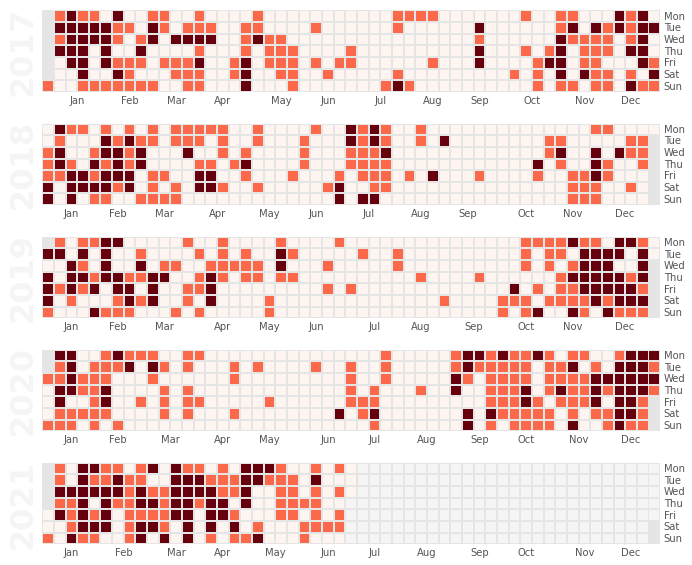

In [ ]:
calmap.calendarplot(data=avg_b,fig_kws=dict(figsize=(16,8)))

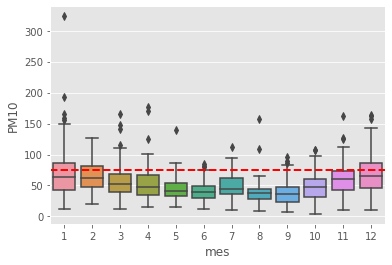

In [ ]:
sns.boxplot(x = df['mes'], y = df['PM10'])
plt.axhline(y = 75, linestyle = '--', color = 'red', lw=2)

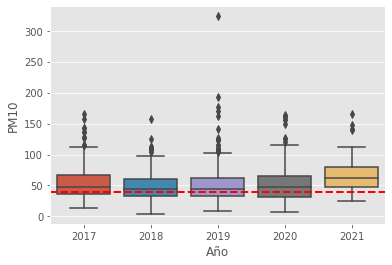

In [ ]:
sns.boxplot(x = df['Año'], y = df['PM10'])
plt.axhline(y = 40, linestyle = '--', color = 'red', lw=2)

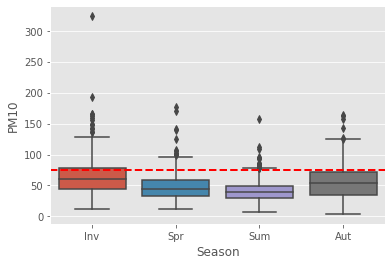

In [ ]:
sns.boxplot(x = df['Season'], y = df['PM10'])
plt.axhline(y = 75, linestyle = '--', color = 'red', lw=2)

##ROSA

In [ ]:
pip install windrose

In [ ]:
import pandas as pd
import numpy as np
import statsmodels as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes

In [ ]:
df=pd.read_csv('dfRosa.csv')

Se crea la variable PM10_pel que separa entre los valores de PM10 dentro y fuera de la norma.

In [ ]:
cat=pd.cut(df['PM10'],bins=[0,75,900],labels=['0','1'])
df.insert(2,'PM10_pel',cat)

Se separa la base de datos entre los datos dentro y fuera de la norma.

In [ ]:
df_0=df.loc[df['PM10_pel'] == '0']

In [ ]:
df_1=df.loc[df['PM10_pel'] == '1']

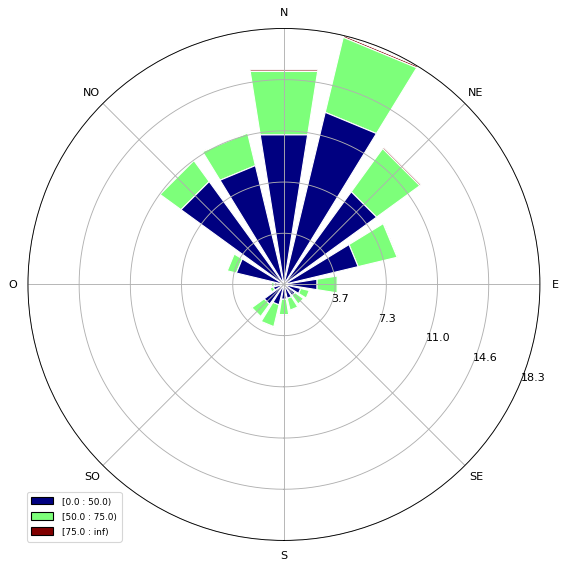

In [ ]:
ax = WindroseAxes.from_ax()
ax.bar(df_0.Rotado, df_0.PM10, normed=True,opening=.8,bins=np.array([0, 50, 75]), edgecolor='white')
ax.set_legend()
ax.set_xticklabels(['S',  'SE','E', 'NE','N', 'NO',  'O','SO', ])
ax.set_theta_zero_location('S')

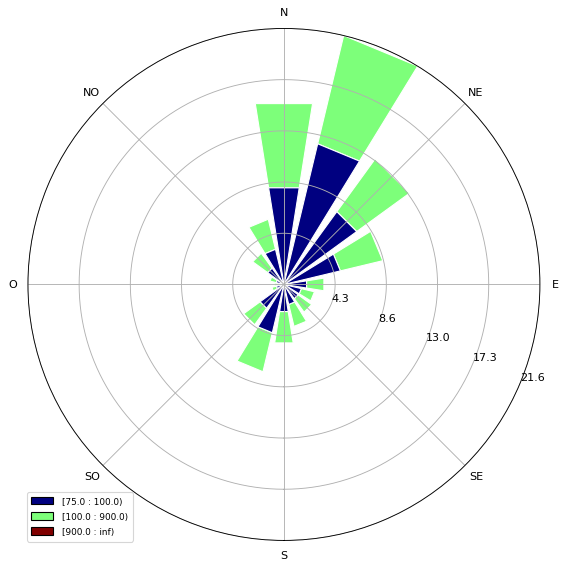

In [ ]:
ax = WindroseAxes.from_ax()
ax.bar(df_1.Rotado, df_1.PM10, normed=True,opening=.8,bins=np.array([75, 100, 900]),edgecolor='white')
ax.set_legend()
ax.set_xticklabels(['S',  'SE','E', 'NE','N', 'NO',  'O','SO', ])
ax.set_theta_zero_location('S')

##Correlaciones

Se obtienen las correlaciones de spearman entre las variables de la base de datos

In [ ]:
corrs = df_sinbadera.iloc[:,1:16].corr('spearman')

Se imprimen todas las correlaciones con la variable a trabajar PM10

In [ ]:
corrs['PM10']

Se obtienen las correlaciones entre las variables de la base de datos

In [ ]:
corrs2 = df_sinbadera.iloc[:,1:16].corr()
corrs2['PM10']

#Análisis de regresión

## Regresión lineal múltiple

Se ajusta un modelo, se eliminan las variables no significativas según el resumen de statsmodels, se eliminan las variables con alto FIV y se repite el proceso hasta que todas las variables sean significativas y tengan FIV menor a 5. Cuando llega ese punto, se revisan los otros supuestos de regresión lineal a través de visualizaciones.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import log
import numpy as np
import scipy as sp

Datos divididos por estación.

In [ ]:
rinv = pd.read_csv('rinv.csv')
rspr = pd.read_csv('rspr.csv')
rsum = pd.read_csv('rsum.csv')
raut = pd.read_csv('raut.csv')

###Invierno

#### Variable dependiente original.

In [ ]:
rinv = rinv.dropna(axis = 0)
rinv.shape

In [ ]:
y = rinv['PM10']
X = rinv.iloc[:,[3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
X = X.drop(['WDR', 'Día', 'mes', 'NOx'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
y_train = y_train.values

In [ ]:
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 15, fontweight = "bold")
axes[0, 0].set_xlabel('Real', fontsize = 14)
axes[0, 0].set_ylabel('Predicción', fontsize = 14)
axes[0, 0].tick_params(labelsize = 12)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 15, fontweight = "bold")
axes[0, 1].set_xlabel('Orden', fontsize = 14)
axes[0, 1].set_ylabel('Residuo', fontsize = 14)
axes[0, 1].tick_params(labelsize = 12)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 15,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo", fontsize = 14)
axes[1, 0].set_ylabel("Densidad", fontsize = 14)
axes[1, 0].tick_params(labelsize = 12)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)


axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 15, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 12)
axes[1, 1].set_xlabel("Cuantiles teóricos", fontsize = 14)
axes[1, 1].set_ylabel("Cuantiles de la muestra", fontsize = 14)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 15, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción', fontsize = 14)
axes[2, 0].set_ylabel('Residuo', fontsize = 14)
axes[2, 0].tick_params(labelsize = 12)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 17, fontweight = "bold");
fig.savefig('Dia_inv_ori.png')

#### Variable dependiente transformada

In [ ]:
y = log(rinv['PM10'])
X = rinv.iloc[:,[3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19]]
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X = X.drop(['Día', 'mes', 'NOx'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
y_train = y_train.values
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 15, fontweight = "bold")
axes[0, 0].set_xlabel('Real', fontsize = 14)
axes[0, 0].set_ylabel('Predicción', fontsize = 14)
axes[0, 0].tick_params(labelsize = 12)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 15, fontweight = "bold")
axes[0, 1].set_xlabel('Orden', fontsize = 14)
axes[0, 1].set_ylabel('Residuo', fontsize = 14)
axes[0, 1].tick_params(labelsize = 12)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 15,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo", fontsize = 14)
axes[1, 0].set_ylabel("Densidad", fontsize = 14)

axes[1, 0].tick_params(labelsize = 12)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 15, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 12)
axes[1, 1].set_xlabel("Cuantiles teóricos", fontsize = 14)
axes[1, 1].set_ylabel("Cuantiles de la muestra", fontsize = 14)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 15, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción', fontsize = 14)
axes[2, 0].set_ylabel('Residuo', fontsize = 14)
axes[2, 0].tick_params(labelsize = 12)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 17, fontweight = "bold");
fig.savefig('Dia_inv_trans.png')

### Primavera

#### Variable dependiente original

In [ ]:
rspr = rspr.dropna(axis = 0)
rspr.shape

In [ ]:
y = rspr['PM10']
X = rspr.iloc[:,[3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X = X.drop(['NO2', 'mes'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
X = X.drop(['NOx'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
X = X.drop(['NO'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
y_train = y_train.values
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 15, fontweight = "bold")
axes[0, 0].set_xlabel('Real', fontsize = 14)
axes[0, 0].set_ylabel('Predicción', fontsize = 14)
axes[0, 0].tick_params(labelsize = 12)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 15, fontweight = "bold")
axes[0, 1].set_xlabel('Orden', fontsize = 14)
axes[0, 1].set_ylabel('Residuo', fontsize = 14)
axes[0, 1].tick_params(labelsize = 12)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 15,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo", fontsize = 14)
axes[1, 0].set_ylabel("Densidad", fontsize = 14)

axes[1, 0].tick_params(labelsize = 12)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 15, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 12)
axes[1, 1].set_xlabel("Cuantiles teóricos", fontsize = 14)
axes[1, 1].set_ylabel("Cuantiles de la muestra", fontsize = 14)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 15, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción', fontsize = 14)
axes[2, 0].set_ylabel('Residuo', fontsize = 14)
axes[2, 0].tick_params(labelsize = 12)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 17, fontweight = "bold");
fig.savefig('Dia_prim_ori.png')

#### Variable dependiente transformada

In [ ]:
y = log(rspr['PM10'])
X = rspr.iloc[:,[3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X = X.drop(['NO2', 'Día'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
X = X.drop(['NOx'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X = X.drop(['NO'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
y_train = y_train.values
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 15, fontweight = "bold")
axes[0, 0].set_xlabel('Real', fontsize = 14)
axes[0, 0].set_ylabel('Predicción', fontsize = 14)
axes[0, 0].tick_params(labelsize = 12)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 15, fontweight = "bold")
axes[0, 1].set_xlabel('Orden', fontsize = 14)
axes[0, 1].set_ylabel('Residuo', fontsize = 14)
axes[0, 1].tick_params(labelsize = 12)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 15,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo", fontsize = 14)
axes[1, 0].set_ylabel("Densidad", fontsize = 14)

axes[1, 0].tick_params(labelsize = 12)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 15, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 12)
axes[1, 1].set_xlabel("Cuantiles teóricos", fontsize = 14)
axes[1, 1].set_ylabel("Cuantiles de la muestra", fontsize = 14)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 15, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción', fontsize = 14)
axes[2, 0].set_ylabel('Residuo', fontsize = 14)
axes[2, 0].tick_params(labelsize = 12)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 17, fontweight = "bold");
fig.savefig('Dia_prim_trans.png')

###Verano

#### Variable dependiente original

In [ ]:
rsum = rsum.dropna(axis = 0)
rsum.shape

In [ ]:
y = rsum['PM10']
X = rsum.iloc[:,[3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X = X.drop(['WDR'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
X = X.drop(['NO', 'NOx'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
y_train = y_train.values
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 15, fontweight = "bold")
axes[0, 0].set_xlabel('Real', fontsize = 14)
axes[0, 0].set_ylabel('Predicción', fontsize = 14)
axes[0, 0].tick_params(labelsize = 12)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 15, fontweight = "bold")
axes[0, 1].set_xlabel('Orden', fontsize = 14)
axes[0, 1].set_ylabel('Residuo', fontsize = 14)
axes[0, 1].tick_params(labelsize = 12)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 15,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo", fontsize = 14)
axes[1, 0].set_ylabel("Densidad", fontsize = 14)

axes[1, 0].tick_params(labelsize = 12)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 15, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 12)
axes[1, 1].set_xlabel("Cuantiles teóricos", fontsize = 14)
axes[1, 1].set_ylabel("Cuantiles de la muestra", fontsize = 14)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 15, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción', fontsize = 14)
axes[2, 0].set_ylabel('Residuo', fontsize = 14)
axes[2, 0].tick_params(labelsize = 12)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 17, fontweight = "bold");
fig.savefig('Dia_ver_ori.png')

#### Variable dependiente transformada

In [ ]:
y = log(rsum['PM10'])
X = rsum.iloc[:,[3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
X = X.drop(['SO2', 'NO2', 'WDR', 'mes'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
X = X.drop(['NOx'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
X = X.drop(['O3', 'CO'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
y_train = y_train.values
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 15, fontweight = "bold")
axes[0, 0].set_xlabel('Real', fontsize = 14)
axes[0, 0].set_ylabel('Predicción', fontsize = 14)
axes[0, 0].tick_params(labelsize = 12)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 15, fontweight = "bold")
axes[0, 1].set_xlabel('Orden', fontsize = 14)
axes[0, 1].set_ylabel('Residuo', fontsize = 14)
axes[0, 1].tick_params(labelsize = 12)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 15,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo", fontsize = 14)
axes[1, 0].set_ylabel("Densidad", fontsize = 14)

axes[1, 0].tick_params(labelsize = 12)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 15, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 12)
axes[1, 1].set_xlabel("Cuantiles teóricos", fontsize = 14)
axes[1, 1].set_ylabel("Cuantiles de la muestra", fontsize = 14)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 15, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción', fontsize = 14)
axes[2, 0].set_ylabel('Residuo', fontsize = 14)
axes[2, 0].tick_params(labelsize = 12)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 17, fontweight = "bold");
fig.savefig('Dia_ver_trans.png')

### Otoño

#### Variable dependiente original

In [ ]:
raut = raut.dropna(axis = 0)
raut.shape

In [ ]:
y = raut['PM10']
X = raut.iloc[:,[3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
X = X.drop(['O3', 'PRS', 'TOUT', 'WDR', 'SR'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
X = X.drop(['NOx'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
X = X.drop(['NO'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
y_train = y_train.values
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 15, fontweight = "bold")
axes[0, 0].set_xlabel('Real', fontsize = 14)
axes[0, 0].set_ylabel('Predicción', fontsize = 14)
axes[0, 0].tick_params(labelsize = 12)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 15, fontweight = "bold")
axes[0, 1].set_xlabel('Orden', fontsize = 14)
axes[0, 1].set_ylabel('Residuo', fontsize = 14)
axes[0, 1].tick_params(labelsize = 12)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 15,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo", fontsize = 14)
axes[1, 0].set_ylabel("Densidad", fontsize = 14)

axes[1, 0].tick_params(labelsize = 12)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 15, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 12)
axes[1, 1].set_xlabel("Cuantiles teóricos", fontsize = 14)
axes[1, 1].set_ylabel("Cuantiles de la muestra", fontsize = 14)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 15, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción', fontsize = 14)
axes[2, 0].set_ylabel('Residuo', fontsize = 14)
axes[2, 0].tick_params(labelsize = 12)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 17, fontweight = "bold");
fig.savefig('Dia_oto_ori.png')

#### Variable dependiente transformada

In [ ]:
y = log(raut['PM10'])
X = raut.iloc[:,[3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X = X.drop(['WDR', 'Día'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X = X.drop(['TOUT'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
X = X.drop(['NOx'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X = X.drop(['NO'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
X_vif = sm.add_constant(X, prepend = True)
pd.Series([variance_inflation_factor(X_vif.values, i) 
               for i in range(X_vif.shape[1])], 
              index=X_vif.columns)

In [ ]:
y_train = y_train.values
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 15, fontweight = "bold")
axes[0, 0].set_xlabel('Real', fontsize = 14)
axes[0, 0].set_ylabel('Predicción', fontsize = 14)
axes[0, 0].tick_params(labelsize = 12)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 15, fontweight = "bold")
axes[0, 1].set_xlabel('Orden', fontsize = 14)
axes[0, 1].set_ylabel('Residuo', fontsize = 14)
axes[0, 1].tick_params(labelsize = 12)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 15,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo", fontsize = 14)
axes[1, 0].set_ylabel("Densidad", fontsize = 14)

axes[1, 0].tick_params(labelsize = 12)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 15, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 12)
axes[1, 1].set_xlabel("Cuantiles teóricos", fontsize = 14)
axes[1, 1].set_ylabel("Cuantiles de la muestra", fontsize = 14)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 15, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción', fontsize = 14)
axes[2, 0].set_ylabel('Residuo', fontsize = 14)
axes[2, 0].tick_params(labelsize = 12)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 17, fontweight = "bold");
fig.savefig('Dia_oto_trans.png')

### Pruebas de hipótesis de diferencia de medias de las variables meteorológicas entre estaciones

In [ ]:
import pandas as pd
from scipy import stats
from statsmodels.stats import weightstats as stests

In [ ]:
rinv = pd.read_csv('rinv.csv')
rspr = pd.read_csv('rspr.csv')
rsum = pd.read_csv('rsum.csv')
raut = pd.read_csv('raut.csv')

Lo siguiente solo recupera las variables meteorológicas.

In [ ]:
rautme = raut.iloc[:,10:17]
rsumme = rsum.iloc[:,10:17]
rinvme = rinv.iloc[:,10:17]

In [ ]:
rautme.describe()

In [ ]:
rsumme.describe()

Ciclo que realiza una prueba de hipótesis por variable.

In [ ]:
for col in rautme.columns:
    print(col)
    ztest ,pval1 = stests.ztest(rautme[col].dropna(), x2= rsumme[col].dropna(), value=0,alternative='two-sided')
    print('ztest:', ztest)
    print('pval1;', pval1)

## Regresor Random Forest

Se importan librerías. Preparación de los datos.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std

In [ ]:
df = pd.read_csv('datos_limpios.csv')
df = df.iloc[:,1:]

In [ ]:
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Date'] = df['Fecha'].dt.date

In [ ]:
y = df['PM10']
X = df.iloc[:,[2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19]]

In [ ]:
X2 = X.iloc[:,[0,2,3,5,7,9,13,15]]
X2

,PM2.5,SO2,CO,NO2,PRS,RH,WSR,mes
0,15.00,3.9,2.23,9.9,708.9,84.0,2.4,2
1,24.00,3.9,2.23,6.8,708.7,89.0,1.2,2
2,24.00,3.9,2.31,9.3,708.7,86.0,1.9,2
3,21.00,3.9,2.26,5.2,708.9,90.0,2.6,2
4,21.00,3.9,2.29,7.0,709.1,90.0,1.7,2
...,...,...,...,...,...,...,...,...
20149,4.33,1.9,1.89,4.3,711.6,79.0,9.4,6
20150,3.75,1.9,1.90,5.5,711.8,77.0,8.8,6
20151,5.51,1.8,1.90,5.5,712.0,82.0,5.8,6
20152,4.14,1.8,1.86,4.2,712.2,82.0,5.2,6


One-Hot Encoding para la variable estación del año.

In [ ]:
a = pd.get_dummies(df['Season'])
X['Aut'] = a['Aut']
X['Inv'] = a['Inv']
X['Spr'] = a['Spr']
X['Sum'] = a['Sum']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle = True
                                    )

Se buscan parámetros óptimos para los random forest.

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 500, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

Se crean los random forest y se evaluan usando Repeated KFold

In [ ]:
rf = RandomForestRegressor(n_estimators = 16,
 min_samples_split = 5,
 min_samples_leaf = 1,
 max_features = 'sqrt',
 max_depth = 57,
 bootstrap = False)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3)
# evaluate model
scores = cross_val_score(rf, X, y, scoring='r2', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.751 (0.049)


In [ ]:
rfscores = cross_val_score(rf, X_test, y_test,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.75


In [ ]:
rf2 = RandomForestRegressor(n_estimators = 16,
 min_samples_split = 5,
 min_samples_leaf = 1,
 max_features = 'sqrt',
 max_depth = 57,
 bootstrap = False)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3)
# evaluate model
scores = cross_val_score(rf2, X2, y, scoring='r2', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.715 (0.042)


## Regresión Lasso

Se importan las librerías

In [ ]:
  import pandas as pd
  import numpy as np
  from sklearn.linear_model import LassoCV

Se prepara el dataframe

In [ ]:
df = pd.read_csv('datos_limpios.csv')

In [ ]:
  df = df.iloc[:,1:]

In [ ]:
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Date'] = df['Fecha'].dt.date

In [ ]:
y = df['PM10']
X = df.iloc[:,[2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19]]

Se grafican los valores absolutos de los coeficientes resultantes de la regresión Lasso.

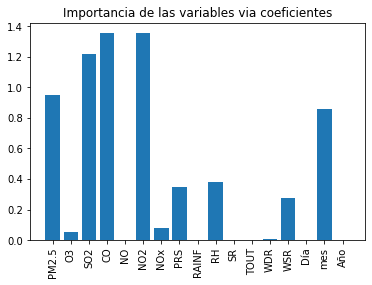

In [ ]:
lasso = LassoCV().fit(X, y)
importance = list(np.abs(lasso.coef_))
feature_names = list(X.columns)
plt.bar(height=importance, x=feature_names)
plt.title("Importancia de las variables via coeficientes")
plt.xticks(rotation=90)
plt.show()

#Análisis de clasificación

In [ ]:
!pip install bioinfokit

In [ ]:
import pandas as pd
import numpy as np
import statsmodels as sm
import scipy.stats as stats
from bioinfokit.analys import stat
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns

Se crea la variable PM10_pel y se inserta en la base de datos

In [ ]:
cat=pd.cut(df['PM10'],bins=[0,75,900],labels=['0','1'])
df.insert(2,'PM10_pel',cat)

Se crea la variable PM25 porque los ANOVAs no pueden utilizar columnas con "." en el nombre

In [ ]:
df['PM25']=df['PM2.5']

##ANOVA

Se realizan ANOVAs entre las variables Peligro y PM10_pel con el resto de la base de datos para obtener las variables significativas para el modelo de clasificación.

Variable Peligro

PM10

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='PM10', anova_model='PM10 ~ C(Peligro)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,1.493562e+07,1.493562e+07,25956.960642,0.0
Residual,20152.0,1.159545e+07,5.753993e+02,NaN,NaN


PM2.5

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='PM25', anova_model='PM25~ C(Peligro)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,1.363897e+06,1.363897e+06,6202.844359,0.0
Residual,20152.0,4.431071e+06,2.198825e+02,NaN,NaN


O3

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='O3', anova_model='O3~ C(Peligro)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,1.844521e+03,1844.521288,4.12022,0.042387
Residual,20152.0,9.021556e+06,447.675463,NaN,NaN


SO2

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='SO2', anova_model='SO2~ C(Peligro)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,11467.631872,11467.631872,1734.639653,0.0
Residual,20152.0,133224.048660,6.610959,NaN,NaN


CO

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='CO', anova_model='CO~ C(Peligro)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,1872.772757,1872.772757,1918.021998,0.0
Residual,20152.0,19676.581731,0.976408,NaN,NaN


NO

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='NO', anova_model='NO~ C(Peligro)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,5.063438e+04,50634.383241,159.160439,2.368952e-36
Residual,20152.0,6.411041e+06,318.134227,NaN,NaN


NO2

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='NO2', anova_model='NO2~ C(Peligro)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,148718.501600,148718.501600,3480.867996,0.0
Residual,20152.0,860985.032265,42.724545,NaN,NaN


NOx

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='NOx', anova_model='NOx~ C(Peligro)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,2.918153e+05,291815.270144,675.587781,1.574131e-146
Residual,20152.0,8.704511e+06,431.942789,NaN,NaN


PRS

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='PRS', anova_model='PRS~ C(Peligro)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,1192.948130,1192.948130,101.513463,8.082635e-24
Residual,20152.0,236818.742025,11.751625,NaN,NaN


RAINF

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='RAINF', anova_model='RAINF~ C(Peligro)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,7.973317e-07,7.973317e-07,0.257101,0.612124
Residual,20152.0,6.249610e-02,3.101236e-06,NaN,NaN


RH

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='RH', anova_model='RH~ C(Peligro)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,2.060189e+05,206018.928312,545.425059,4.736639e-119
Residual,20152.0,7.611849e+06,377.721788,NaN,NaN


SR

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='SR', anova_model='SR~ C(Peligro)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,25.462476,25.462476,643.162141,1.060239e-139
Residual,20152.0,797.807871,0.039590,NaN,NaN


Variable PM10_pel

PM10

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='PM10', anova_model='PM10 ~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,1.493562e+07,1.493562e+07,25956.960642,0.0
Residual,20152.0,1.159545e+07,5.753993e+02,NaN,NaN


PM2.5

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='PM25', anova_model='PM25~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,1.363897e+06,1.363897e+06,6202.844359,0.0
Residual,20152.0,4.431071e+06,2.198825e+02,NaN,NaN


O3

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='O3', anova_model='O3~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,1.844521e+03,1844.521288,4.12022,0.042387
Residual,20152.0,9.021556e+06,447.675463,NaN,NaN


SO2

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='SO2', anova_model='SO2~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,11467.631872,11467.631872,1734.639653,0.0
Residual,20152.0,133224.048660,6.610959,NaN,NaN


CO

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='CO', anova_model='CO~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,1872.772757,1872.772757,1918.021998,0.0
Residual,20152.0,19676.581731,0.976408,NaN,NaN


NO

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='NO', anova_model='NO~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,5.063438e+04,50634.383241,159.160439,2.368952e-36
Residual,20152.0,6.411041e+06,318.134227,NaN,NaN


NO2

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='NO2', anova_model='NO2~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,148718.501600,148718.501600,3480.867996,0.0
Residual,20152.0,860985.032265,42.724545,NaN,NaN


NOx

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='NOx', anova_model='NOx~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,2.918153e+05,291815.270144,675.587781,1.574131e-146
Residual,20152.0,8.704511e+06,431.942789,NaN,NaN


PRS

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='PRS', anova_model='PRS~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,1192.948130,1192.948130,101.513463,8.082635e-24
Residual,20152.0,236818.742025,11.751625,NaN,NaN


RAINF

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='RAINF', anova_model='RAINF~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,7.973317e-07,7.973317e-07,0.257101,0.612124
Residual,20152.0,6.249610e-02,3.101236e-06,NaN,NaN


RH

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='RH', anova_model='RH~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,2.060189e+05,206018.928312,545.425059,4.736639e-119
Residual,20152.0,7.611849e+06,377.721788,NaN,NaN


SR

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='SR', anova_model='SR~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,25.462476,25.462476,643.162141,1.060239e-139
Residual,20152.0,797.807871,0.039590,NaN,NaN


TOUT

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='TOUT', anova_model='TOUT~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,341.838267,341.838267,8.396646,0.003763
Residual,20152.0,820413.888323,40.711289,NaN,NaN


WDR

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='WDR', anova_model='WDR~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,6.259599e+05,625959.909977,84.70834,3.786766e-20
Residual,20152.0,1.489150e+08,7389.590074,NaN,NaN


WSR

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='WSR', anova_model='WSR~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,3638.619927,3638.619927,303.233859,2.027518e-67
Residual,20152.0,241811.613704,11.999385,NaN,NaN


Día

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='Día', anova_model='Día~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,1.019019e+03,1019.019368,13.075712,0.0003
Residual,20152.0,1.570490e+06,77.932230,NaN,NaN


Mes

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='mes', anova_model='mes~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,123.753826,123.753826,10.979333,0.000923
Residual,20152.0,227143.763887,11.271525,NaN,NaN


Año

In [ ]:
res = stat()
res.anova_stat(df=df, res_var='Año', anova_model='Año~ C(PM10_pel)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(PM10_pel),1.0,371.021038,371.021038,210.644135,1.725813e-47
Residual,20152.0,35495.011363,1.761364,NaN,NaN


##LDA

Función para hacer las matrices de confusión más faciles de ver.

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            stats_text = "\n\nExactitud={:0.3f}\nPrecisión={:0.3f}\nSensibilidad={:0.3f}".format(
                accuracy,precision,recall)
        else:
            stats_text = "\n\nExactitud={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Valor original')
        plt.xlabel('Valor predicho' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

LDA con variable Peligro

Se eligen las variables significativas resultantes de los ANOVAs

In [ ]:
y = df['Peligro']
X = df.iloc[:,[4,6,7,8,9,10,11,13,14,16,17,19,20]]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies=cross_val_score(estimator=clf,X=X_train, y=y_train, cv=10)
print('Accuracy: {:.2f} %'.format(accuracies.mean()*100))
print('Standard Deviation {:.2f} %'.format(accuracies.std()*100))

Accuracy: 68.06 %
Standard Deviation 1.14 %


In [ ]:
y_pred=clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6827090052096254

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred,average=None)

array([0.9315518 , 0.22211538, 0.62237762])

In [ ]:
from sklearn.metrics import recall_score
precision_score(y_test, y_pred,average=None)

array([0.70261669, 0.51219512, 0.71010638])

In [ ]:
confusion_matrix(y_test, y_pred)

array([[1987,   91,   55],
       [ 646,  231,  163],
       [ 195,  129,  534]])

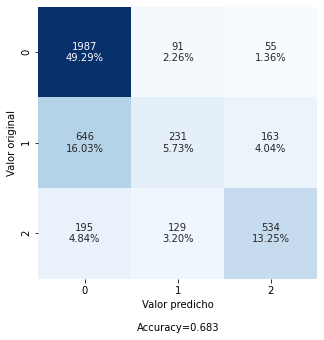

In [ ]:
cf_matrix=confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, figsize=(5,5), cbar=False)

LDA con variable PM10_pel

In [ ]:
y = df['PM10_pel']
X = df.iloc[:,[4,6,7,8,9,10,11,13,14,16,17,19,20]]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies=cross_val_score(estimator=clf,X=X_train, y=y_train, cv=10)
print('Accuracy: {:.2f} %'.format(accuracies.mean()*100))
print('Standard Deviation {:.2f} %'.format(accuracies.std()*100))

Accuracy: 85.93 %
Standard Deviation 0.69 %


In [ ]:
y_pred=clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8655420491193252

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred,average=None)

array([0.95525657, 0.52215569])

In [ ]:
from sklearn.metrics import recall_score
precision_score(y_test, y_pred,average=None)

array([0.88441483, 0.75302245])

In [ ]:
confusion_matrix(y_test, y_pred)

array([[3053,  143],
       [ 399,  436]])

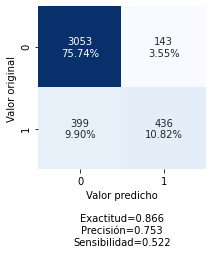

In [ ]:
cf_matrix=confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, figsize=(3,3), cbar=False)

Random Forest (PM10_pel)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 500, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 22.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 67,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 393}

In [ ]:
rf = RandomForestClassifier(n_estimators = 393,
 min_samples_split = 5,
 min_samples_leaf = 1,
 max_features = 'auto',
 max_depth = 67,
 bootstrap = False)

In [ ]:
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3)
# evaluate model
scores = cross_val_score(rf, X_test, y_test,cv=cv)
# report performance
print('Accuracy: %.3f (%.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.893 (0.017)


In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=67, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=393,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_predrf=rf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predrf)

0.9136690647482014

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, y_predrf,average=None)

array([0.96370463, 0.72215569])

In [ ]:
from sklearn.metrics import recall_score
precision_score(y_test, y_predrf,average=None)

array([0.92995169, 0.83866481])

In [ ]:
confusion_matrix(y_test, y_predrf)

array([[3080,  116],
       [ 232,  603]])

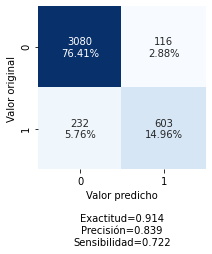

In [ ]:
cf_matrix=confusion_matrix(y_test, y_predrf)
make_confusion_matrix(cf_matrix, figsize=(3,3), cbar=False)

#Reducción de dimensionalidad

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
df_sb = pd.read_csv('df_ANOVA.csv')
target=df_sb[["Fecha","Season"]]
df_sb

,Unnamed: 0,Fecha,PM10,PM2.5,O3,SO2,CO,NO,NO2,NOx,PRS,RAINF,RH,SR,TOUT,WDR,WSR,Date,Día,mes,Año,dia-mes,Season,Peligro
0,1369,2017-02-27 01:00:00,51.0,15.00,8.0,3.9,2.23,2.8,9.9,12.6,708.9,0.0,84.0,0.006,18.88,18.0,2.4,2017-02-27,27,2,2017,27-02 01:00,Inv,2
1,1370,2017-02-27 02:00:00,57.0,24.00,9.0,3.9,2.23,2.5,6.8,9.3,708.7,0.0,89.0,0.003,18.27,277.0,1.2,2017-02-27,27,2,2017,27-02 02:00,Inv,2
2,1371,2017-02-27 03:00:00,63.0,24.00,6.0,3.9,2.31,2.9,9.3,12.2,708.7,0.0,86.0,0.004,17.84,257.0,1.9,2017-02-27,27,2,2017,27-02 03:00,Inv,2
3,1372,2017-02-27 04:00:00,59.0,21.00,13.0,3.9,2.26,2.5,5.2,7.7,708.9,0.0,90.0,0.004,17.50,299.0,2.6,2017-02-27,27,2,2017,27-02 04:00,Inv,2
4,1373,2017-02-27 05:00:00,50.0,21.00,8.0,3.9,2.29,2.7,7.0,9.8,709.1,0.0,90.0,0.006,16.78,272.0,1.7,2017-02-27,27,2,2017,27-02 05:00,Inv,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20149,39389,2021-06-30 19:00:00,24.0,4.33,19.0,1.9,1.89,1.8,4.3,6.3,711.6,0.0,79.0,0.040,23.31,99.0,9.4,2021-06-30,30,6,2021,30-06 19:00,Sum,1
20150,39390,2021-06-30 20:00:00,25.0,3.75,17.0,1.9,1.90,1.9,5.5,7.7,711.8,0.0,77.0,0.010,23.51,74.0,8.8,2021-06-30,30,6,2021,30-06 20:00,Sum,1
20151,39391,2021-06-30 21:00:00,21.0,5.51,16.0,1.8,1.90,1.6,5.5,7.2,712.0,0.0,82.0,0.000,22.62,73.0,5.8,2021-06-30,30,6,2021,30-06 21:00,Sum,1
20152,39392,2021-06-30 22:00:00,24.0,4.14,18.0,1.8,1.86,1.5,4.2,5.8,712.2,0.0,82.0,0.000,22.58,61.0,5.2,2021-06-30,30,6,2021,30-06 22:00,Sum,1


Creación de la función de PCA

In [ ]:
def PCA_gen(df,p):
    #Separación de varaibles y el color
    X=df.iloc[:,2:17]
    cols=list(X.columns)
    cols.append('ratio')
    x = X.to_numpy()
    x = StandardScaler().fit_transform(x)
    y = df['Peligro']  
    
    #Se define el número de componentes y se aplica la función de PCA de Scikit Learn
    pca = PCA(n_components=7)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2','principal component 3',
                                                                    'principal component 4','principal component 5','principal component 6',
                                                                    'principal component 7'])
    finalDf = pd.concat([principalDf, df[['Peligro']]], axis = 1)

    #Se agrega el puntaje de las variables a una tabla
    a=(pca.explained_variance_ratio_.reshape(-1,len(pca.explained_variance_ratio_)))[0].tolist()
    comps = pd.DataFrame(data = pca.components_.transpose(), columns = ['principal component 1', 'principal component 2','principal component 3',
                                                                    'principal component 4','principal component 5','principal component 6',
                                                                    'principal component 7'])
    comps_length = len(comps)
    comps.loc[comps_length] = a
    comps.index=cols

    #Imprime gráficas en 2 y 3 dimensiones y devuelve los puntajes o la variabilidad de las variables por componente
    if (p==1):
        fig = plt.figure(figsize = (12,12))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('Componenete Principal 1', fontsize = 15)
        ax.set_ylabel('Componenete Principal 2', fontsize = 15)
        ax.set_title('PCA de 2 Componentes', fontsize = 20)
        targets = [1,2,3]
        colors = ['m','y','darkorange']
        for target, color in zip(targets,colors):
            indicesToKeep = finalDf['Peligro'] == target
            ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                        , finalDf.loc[indicesToKeep, 'principal component 2']
                        , c = color
                        , s = 50)
        ax.legend(targets)
        ax.grid() 

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.set_xlabel('Componenete Principal 1', fontsize = 15)
        ax.set_ylabel('Componenete Principal 2', fontsize = 15)
        ax.set_zlabel('Componenete Principal 3', fontsize = 15)
        ax.set_title('PCA de 3 Componentes', fontsize = 20)
        targets = [1,2,3]
        colors = ['m','y','darkorange']
        for target, color in zip(targets,colors):
            indicesToKeep = finalDf['Peligro'] == target
            ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                        , finalDf.loc[indicesToKeep, 'principal component 2']
                        , finalDf.loc[indicesToKeep, 'principal component 3']
                        , c = color
                        , s = 50)
        ax.legend(targets)
        ax.grid()
        return comps
    elif(p==0):
        finalDf=finalDf.drop(['Peligro'], axis = 1)
        return finalDf
    

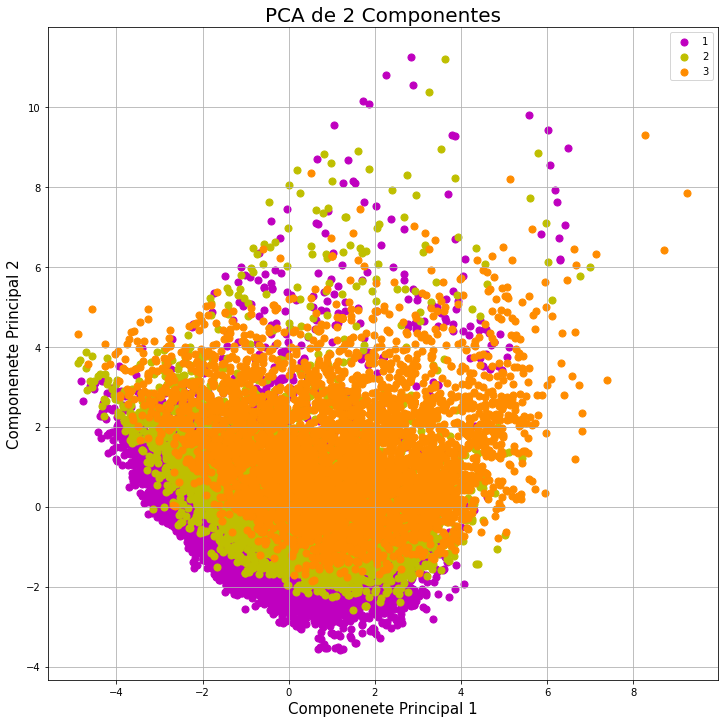

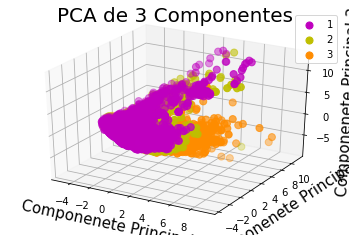

In [ ]:
comps=PCA_gen(df_sb,1)
scrs=PCA_gen(df_sb,0)

# Análisis de Conglomerados

Se aplica el método del codo para definir el número de conglomerados para separar

In [ ]:
def Elbow(df,r):
    distortions = []
    K = range(1,r)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

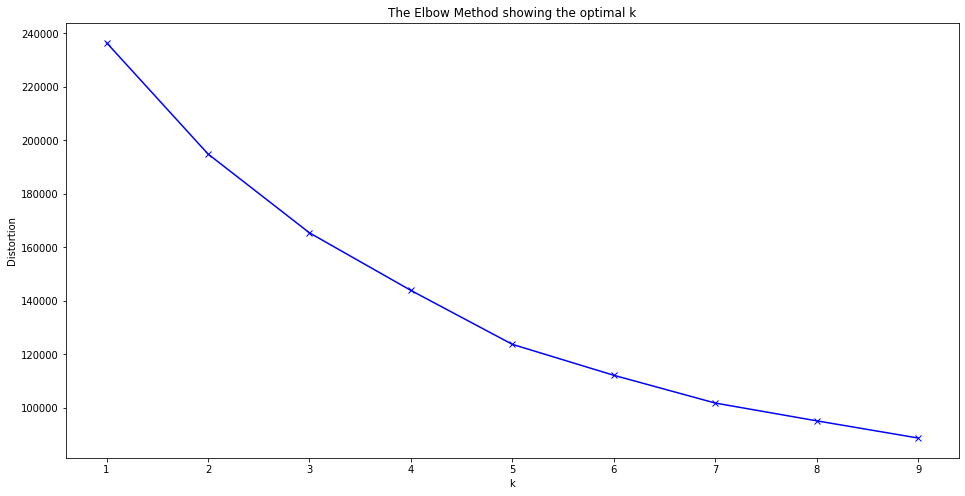

In [ ]:
Elbow(scrs,10)

Se aplica la función de KMeans de Scikit Learn

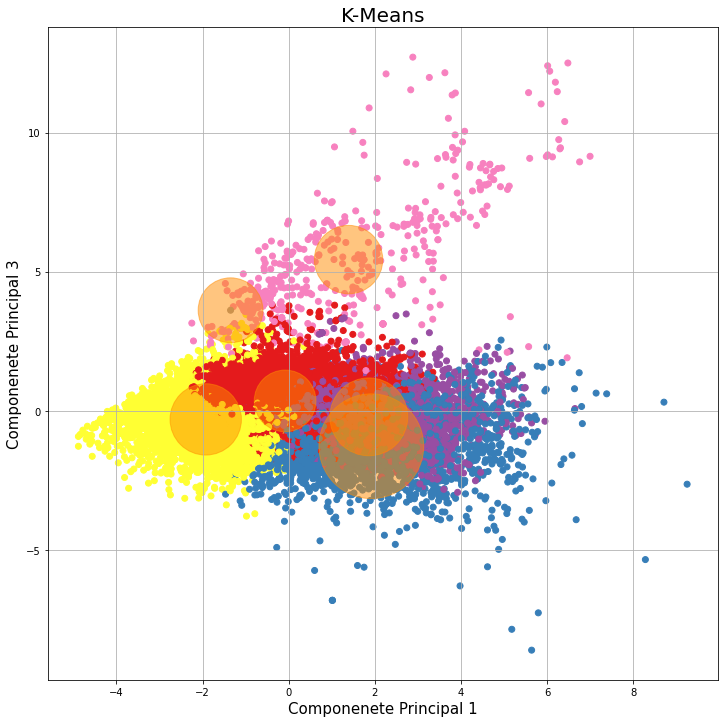

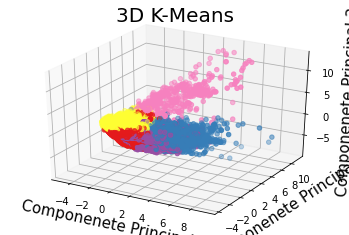

In [ ]:
#Se define el número de clusters y las variables a agrupar
kmeanModel = KMeans(n_clusters=6)
kmeanModel.fit(scrs.iloc[:,0:7])

km=scrs

#Se extraen los grupos asignados y los centroides de cada grupo
km['k_means']=kmeanModel.predict(km.iloc[:,0:7])
centroids  = kmeanModel.cluster_centers_

index_l=[]
PM10_mean=[]
c=pd.DataFrame(centroids)

#Se extraen los índices de los datos por grupo y después se saca el promedio de PM10 de los datos dentro de ese grupo
for i in range(6):
    index_l.append(list(km.loc[km['k_means'] == i].index))

for l in index_l:
    PM10_mean.append(df_sb.iloc[l]['PM10'].mean())

c['PM10m']=PM10_mean

#Se hace una gráfica en 2 y 3 dimensiones de todos los datos coloreados por el grupo en el que se encuentran

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Componenete Principal 1', fontsize = 15)
ax.set_ylabel('Componenete Principal 3', fontsize = 15)
ax.set_title('K-Means', fontsize = 20)
ax.scatter(km['principal component 1'], km['principal component 3'], c=km['k_means'], cmap=plt.cm.Set1)
#Se yuxtapone la gráfica de burbuja en los datos
plt.scatter(c[0], c[2], s=c['PM10m']*100, alpha=0.5, c = 'darkorange', cmap=plt.cm.Set1)
ax.grid()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('Componenete Principal 1', fontsize = 15)
ax.set_ylabel('Componenete Principal 2', fontsize = 15)
ax.set_zlabel('Componenete Principal 3', fontsize = 15)
ax.set_title('3D K-Means', fontsize = 20)
ax.scatter(km['principal component 1']
            , km['principal component 2']
            , km['principal component 3']
            , c = km['k_means']
            , cmap=plt.cm.Set1)
ax.grid()

Se realiza un gráfico de burbuja en las coordenadas de los centroides de cada grupo donde el tamaño de la burbuja es relativo al promedio de PM10 dentro de ese grupo

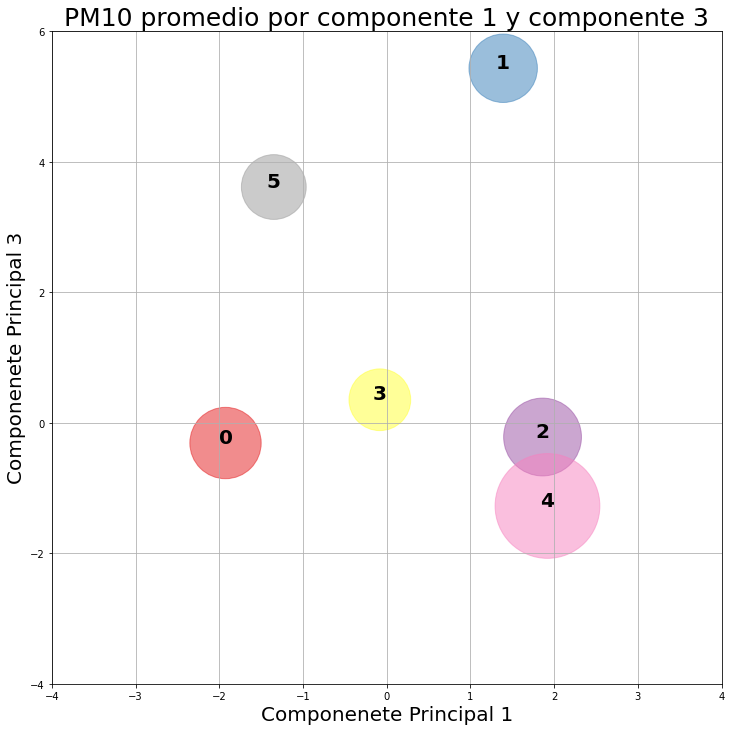

In [ ]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Componenete Principal 1', fontsize = 20)
ax.set_ylabel('Componenete Principal 3', fontsize = 20)
ax.set_title('PM10 promedio por componente 1 y componente 3', fontsize = 25)
ax.set(xlim=(-4, 4), ylim=(-4, 6))
plt.scatter(c[0], c[2], s=c['PM10m']*100, alpha=0.5, c = [0,1,2,3,4,5], cmap=plt.cm.Set1)

for line in range(0,c.shape[0]):
    ax.text(c[0][line], c[2][line], c.index[line], horizontalalignment='center', size='medium', color='black', weight='semibold',fontsize=20)

plt.grid()